In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
!pip install scikit-learn==0.24
!pip install delayed
!pip install scikit-survival
!pip install eli5
!pip install lifelines

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
import sksurv
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/colab_data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
data = pd.read_csv(os.path.join(path, "WA_Fn-UseC_-Telco-Customer-Churn.csv"))
data['Churn'] = data['Churn'].apply(lambda x: np.where(x=='Yes',1,0))
data['entry_age'] = 0
data = data[data.tenure>data.entry_age]
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])
data[data.select_dtypes(['object']).columns] = data.select_dtypes(['object']).apply(lambda x: x.astype('category'))
data.head(3)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,entry_age
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0


## Survival Tree (sksurv)

In [17]:
X, y = sksurv.datasets.get_x_y(data, ['Churn','tenure'], pos_label=1, survival=True)

In [20]:
# Reference: https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html
feature_names = ['SeniorCitizen', 
                    'Partner', 
                    'Dependents', 
#                     'PhoneService', 'MultipleLines', 'InternetService', 
#                     'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
#                     'TechSupport', 'StreamingTV', 'StreamingMovies', 
#                     'Contract', 'PaperlessBilling', 'PaymentMethod', 
                    'MonthlyCharges', 
                    'TotalCharges', 
                    'gender', 'entry_age']
Xt = X[feature_names]


Xt = OneHotEncoder().fit_transform(Xt)


In [21]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

In [24]:
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_jobs=-1, random_state=20)

In [25]:
rsf.score(X_test, y_test) #concordance index

0.9002133111279444

In [28]:
X_test_sel = X_test.head(3)
print(X_test_sel)
pd.Series(rsf.predict(X_test_sel))

      SeniorCitizen  Partner=Yes  ...  gender=Male  entry_age
6610              0          0.0  ...          1.0          0
6785              0          0.0  ...          1.0          0
7018              0          1.0  ...          1.0          0

[3 rows x 7 columns]


0    105.119691
1      5.184091
2     83.870430
dtype: float64

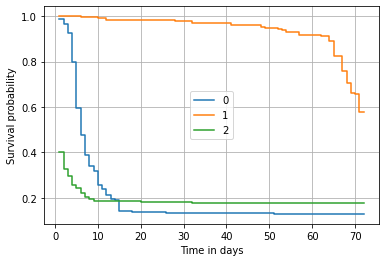

In [29]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

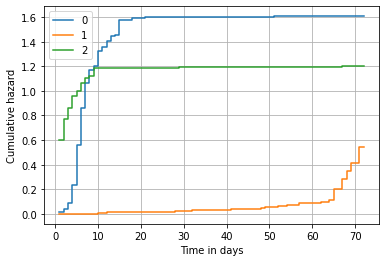

In [30]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [32]:

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15, random_state=random_state)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)

     |████████████████████████████████| 106 kB 8.1 MB/s 


Weight,Feature
0.3324 ± 0.0208,TotalCharges
0.1661 ± 0.0157,MonthlyCharges
0.0036 ± 0.0026,Partner
0.0025 ± 0.0039,Dependents
0.0002 ± 0.0028,SeniorCitizen
0.0000 ± 0.0022,gender
0 ± 0.0000,entry_age


In [45]:
y_test

array([(False,  5.), ( True, 61.), ( True,  1.), ..., (False, 50.),
       (False, 29.), (False, 11.)],
      dtype=[('Churn', '?'), ('tenure', '<f8')])

## C-index

Reference: https://medium.com/analytics-vidhya/concordance-index-72298c11eac7

Notice that lifelines gives the concordance between the actual event times and the predicted scores, while scikit-survival gives the concordance between the actuals and the predicted risks, so over the same lists, they are the complete opposite. Scikit-survival also gives the number of concordant pairs, number of discordant pairs, number of pairs having tied estimated risks, and the number of comparable pairs sharing the same time.

Concordance index (lifelines) = 1-Concordance index (scikit-survival)

Concordance index from **scikit-survival** -> 1 means **perfect results**.

In [47]:
# Calculate C-Index 
from lifelines.utils import concordance_index
test_churn = [x[1] for x in y_test]
test_event_obs = [x[0] for x in y_test]
print(test_churn)
print(test_event_obs)
y_test_pred = rsf.predict(X_test)
print(y_test_pred)
concordance_index(test_churn, y_test_pred, test_event_obs) # to make this index has the same logic as real c-index, we need to write it as concordance_index(test_churn, -y_test_pred, test_event_obs)

[5.0, 61.0, 1.0, 64.0, 60.0, 56.0, 19.0, 1.0, 31.0, 10.0, 69.0, 1.0, 39.0, 1.0, 67.0, 8.0, 4.0, 58.0, 61.0, 4.0, 4.0, 35.0, 53.0, 22.0, 29.0, 12.0, 52.0, 39.0, 1.0, 53.0, 1.0, 72.0, 44.0, 27.0, 12.0, 71.0, 68.0, 15.0, 64.0, 46.0, 25.0, 70.0, 45.0, 16.0, 71.0, 13.0, 41.0, 72.0, 46.0, 10.0, 24.0, 1.0, 48.0, 26.0, 20.0, 72.0, 15.0, 29.0, 7.0, 25.0, 2.0, 60.0, 64.0, 43.0, 42.0, 15.0, 5.0, 72.0, 72.0, 14.0, 67.0, 24.0, 51.0, 5.0, 1.0, 9.0, 27.0, 12.0, 13.0, 18.0, 46.0, 30.0, 68.0, 1.0, 45.0, 1.0, 52.0, 7.0, 54.0, 68.0, 68.0, 1.0, 28.0, 72.0, 9.0, 47.0, 27.0, 1.0, 72.0, 12.0, 15.0, 6.0, 1.0, 43.0, 1.0, 72.0, 1.0, 5.0, 15.0, 34.0, 23.0, 26.0, 72.0, 72.0, 1.0, 23.0, 64.0, 68.0, 10.0, 58.0, 1.0, 71.0, 40.0, 33.0, 47.0, 71.0, 57.0, 14.0, 64.0, 11.0, 9.0, 15.0, 66.0, 42.0, 63.0, 11.0, 70.0, 35.0, 57.0, 38.0, 20.0, 3.0, 23.0, 68.0, 4.0, 17.0, 7.0, 51.0, 3.0, 11.0, 53.0, 71.0, 56.0, 53.0, 23.0, 35.0, 34.0, 68.0, 24.0, 70.0, 72.0, 52.0, 34.0, 51.0, 67.0, 14.0, 35.0, 49.0, 1.0, 11.0, 1.0, 22.0, 1.0, 

0.09978668887205551

In [48]:
from sksurv.metrics import concordance_index_censored as ci_scikit
ci_scikit(test_event_obs, test_churn, y_test_pred)[0]

(0.9002133111279444, 490801, 54398, 14, 12303)